# Problem 5 — Q-learning on FrozenLake

Environment: 4x4 | States: 16, Actions: 4
Using algorithm: Q-learning (off-policy)
Ep 500/20000 | Last500 avg: 0.036 | Eps: 0.779 | MaxQ: 0.94
Ep 1000/20000 | Last500 avg: 0.064 | Eps: 0.606 | MaxQ: 0.98
Ep 1500/20000 | Last500 avg: 0.098 | Eps: 0.472 | MaxQ: 0.97
Ep 2000/20000 | Last500 avg: 0.208 | Eps: 0.368 | MaxQ: 1.00
Ep 2500/20000 | Last500 avg: 0.304 | Eps: 0.286 | MaxQ: 0.99
Ep 3000/20000 | Last500 avg: 0.428 | Eps: 0.223 | MaxQ: 0.95
Ep 3500/20000 | Last500 avg: 0.502 | Eps: 0.174 | MaxQ: 0.99
Ep 4000/20000 | Last500 avg: 0.584 | Eps: 0.135 | MaxQ: 0.98
Ep 4500/20000 | Last500 avg: 0.626 | Eps: 0.105 | MaxQ: 0.97
Ep 5000/20000 | Last500 avg: 0.712 | Eps: 0.082 | MaxQ: 1.00
Ep 5500/20000 | Last500 avg: 0.794 | Eps: 0.064 | MaxQ: 0.99
Ep 6000/20000 | Last500 avg: 0.844 | Eps: 0.050 | MaxQ: 1.00
Ep 6500/20000 | Last500 avg: 0.858 | Eps: 0.039 | MaxQ: 0.86
Ep 7000/20000 | Last500 avg: 0.874 | Eps: 0.030 | MaxQ: 1.00
Ep 7500/20000 | Last500 avg: 0.918 | Eps: 0.023 | MaxQ: 1.00
Ep 

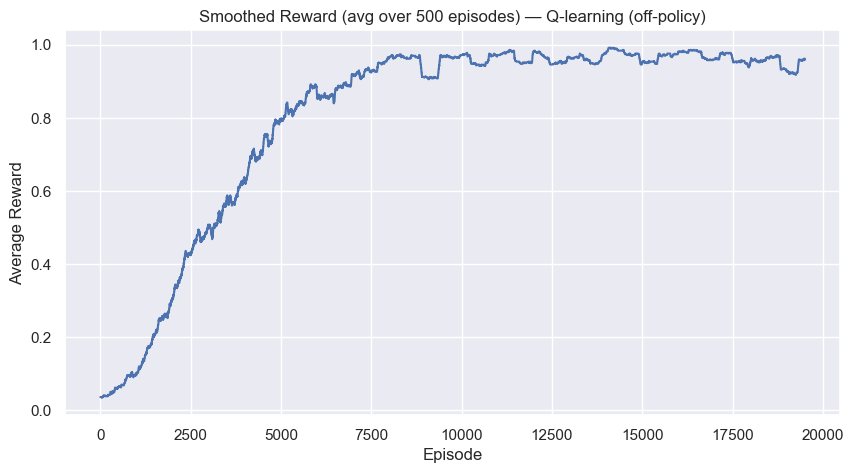

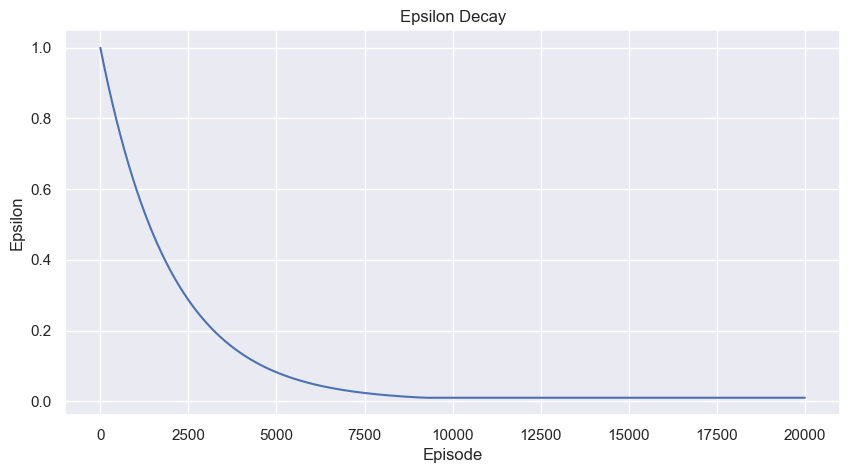

In [7]:
# =====================================
# Problem 5 – Q-learning & SARSA on FrozenLake
# Automatic: Q-learning (4x4) / SARSA (8x8)
# =====================================

import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
CONFIG = {
    'env_name': 'FrozenLake-v1',
    'map_name': '4x4',             # '4x4' → Q-learning, '8x8' → SARSA
    'is_slippery': True,           # Keep True for challenge
    'alpha': 0.3,                  # Learning rate
    'gamma': 0.99,                 # Discount factor
    'epsilon': 1.0,                # Starting exploration rate
    'epsilon_min': 0.01,
    'epsilon_decay': 0.9995,       # slower decay for large maps
    'episodes': 20000,             # more episodes for 8x8
    'max_steps': 200,              # allow more steps per episode
    'seed': 42
}

# --- Set seeds ---
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# --- Initialize environment ---
env = gym.make(CONFIG['env_name'], map_name=CONFIG['map_name'], is_slippery=CONFIG['is_slippery'])
env.reset(seed=CONFIG['seed'])
n_states = env.observation_space.n
n_actions = env.action_space.n
print(f"Environment: {CONFIG['map_name']} | States: {n_states}, Actions: {n_actions}")

# --- Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.Q = np.zeros((n_states, n_actions))

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        return np.argmax(self.Q[state])

    def update(self, s, a, r, s_next, done):
        best_next = np.max(self.Q[s_next])
        target = r + (0 if done else self.gamma * best_next)
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# --- SARSA Agent (on-policy) ---
class SARSAAgent(QLearningAgent):
    def update(self, s, a, r, s_next, done, a_next):
        target = r + (0 if done else self.gamma * self.Q[s_next, a_next])
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

# --- Select algorithm ---
if CONFIG['map_name'] == '8x8':
    agent = SARSAAgent(n_states, n_actions,
                       CONFIG['alpha'], CONFIG['gamma'],
                       CONFIG['epsilon'], CONFIG['epsilon_min'],
                       CONFIG['epsilon_decay'])
    algo_name = "SARSA (on-policy)"
else:
    agent = QLearningAgent(n_states, n_actions,
                           CONFIG['alpha'], CONFIG['gamma'],
                           CONFIG['epsilon'], CONFIG['epsilon_min'],
                           CONFIG['epsilon_decay'])
    algo_name = "Q-learning (off-policy)"

print(f"Using algorithm: {algo_name}")

# --- Training Loop ---
rewards_per_episode = []
epsilons = []

for episode in range(CONFIG['episodes']):
    state, _ = env.reset(seed=CONFIG['seed'])
    total_reward = 0

    # choose first action (SARSA needs it)
    action = agent.choose_action(state)

    for step in range(CONFIG['max_steps']):
        next_state, reward, done, truncated, _ = env.step(action)

        # Reward shaping (helps learning in 8x8)
        if CONFIG['map_name'] == '8x8' and reward == 0 and not done:
            reward = -0.01

        if isinstance(agent, SARSAAgent):
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, next_state, done, next_action)
            action = next_action
        else:
            agent.update(state, action, reward, next_state, done)
            action = agent.choose_action(next_state)

        state = next_state
        total_reward += reward
        if done or truncated:
            break

    agent.decay_epsilon()
    rewards_per_episode.append(total_reward)
    epsilons.append(agent.epsilon)

    # --- Live feedback ---
    if (episode + 1) % 500 == 0:
        avg = np.mean(rewards_per_episode[-500:])
        print(f"Ep {episode + 1}/{CONFIG['episodes']} | "
              f"Last500 avg: {avg:.3f} | "
              f"Eps: {agent.epsilon:.3f} | MaxQ: {agent.Q.max():.2f}")

print("\nTraining completed ✅")

# --- Evaluation (greedy policy) ---
n_eval_episodes = 200
successes = 0
steps_list = []

for _ in range(n_eval_episodes):
    state, _ = env.reset(seed=CONFIG['seed'])
    for step in range(CONFIG['max_steps']):
        action = np.argmax(agent.Q[state])
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        if done or truncated:
            if reward > 0:
                successes += 1
            steps_list.append(step + 1)
            break

success_rate = successes / n_eval_episodes
print(f"Evaluation over {n_eval_episodes} episodes ({algo_name}):")
print(f"  Success rate: {success_rate*100:.1f}%")
print(f"  Avg steps (successful episodes): {np.mean(steps_list) if steps_list else 0:.2f}")

# --- Inspect learned Q-values ---
print("\nSample Q-values (first 10 states):")
print(agent.Q[:10])

# --- Plot learning progress ---
sns.set(style="darkgrid")
window = 500
smoothed_rewards = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(smoothed_rewards)
plt.title(f"Smoothed Reward (avg over {window} episodes) — {algo_name}")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epsilons)
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()